--- LOADING DATA ---
Nodes: 8521
Links: 28788
Performance Records: 28788

--- START MAP GENERATION (Congestion V/C) ---
Indexed 8521 nodes.
Constructing geometries...
Valid geometries created for 28788 links.
Filtered road links: 14173 (connectors excluded)
Generating plot...


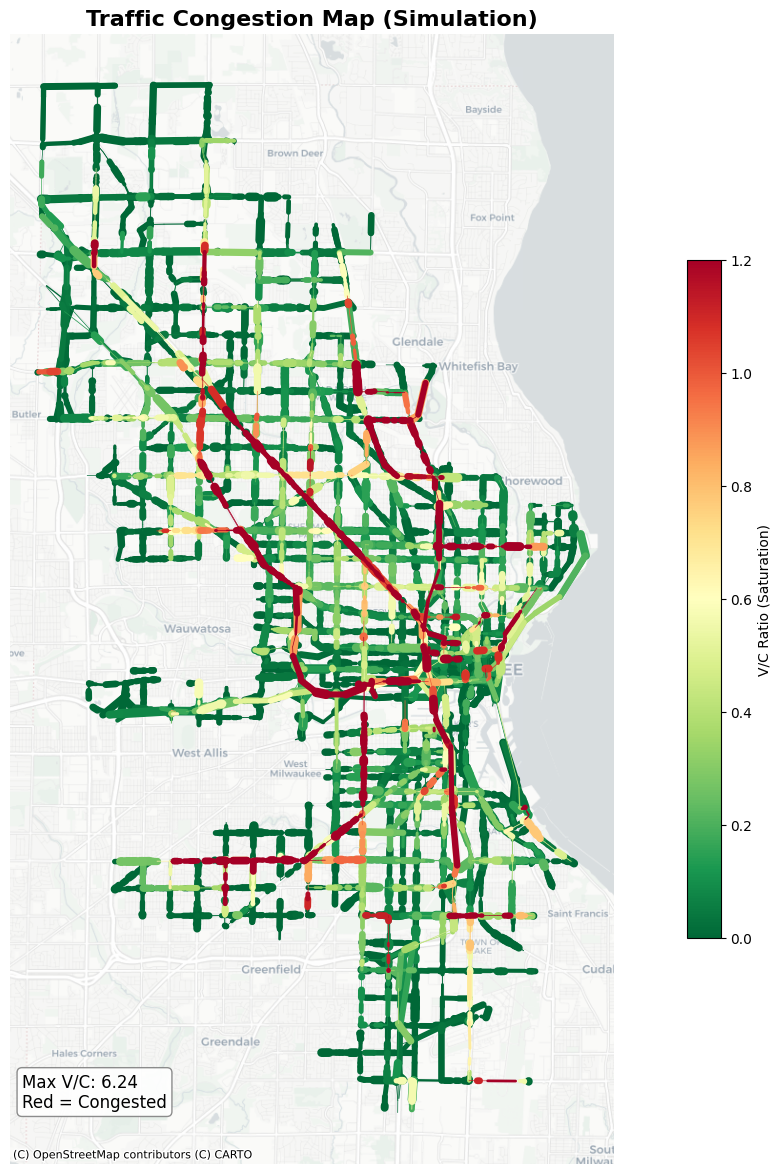

Done.

--- START MAP GENERATION (Delay) ---
Reconstructing geometries from nodes...
Calculating delay using real time column: travel_time


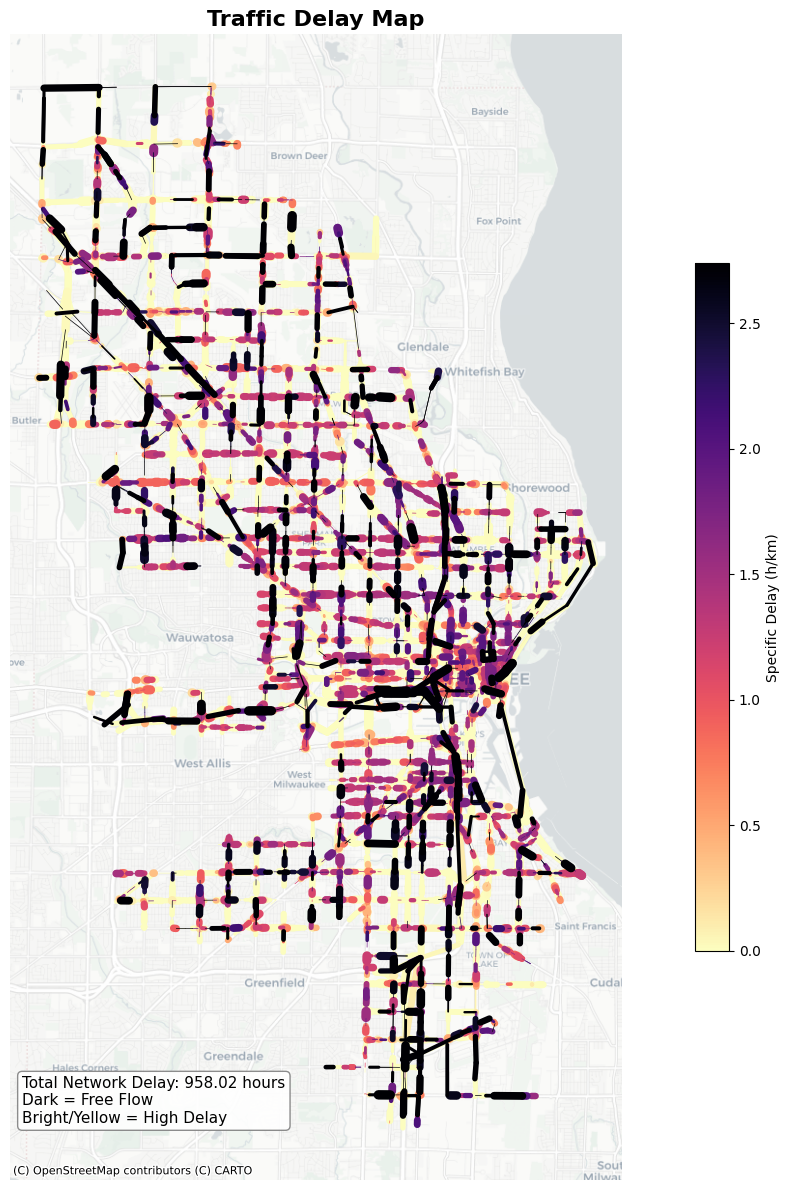


--- START MAP GENERATION (Infrastructure Capacity) ---


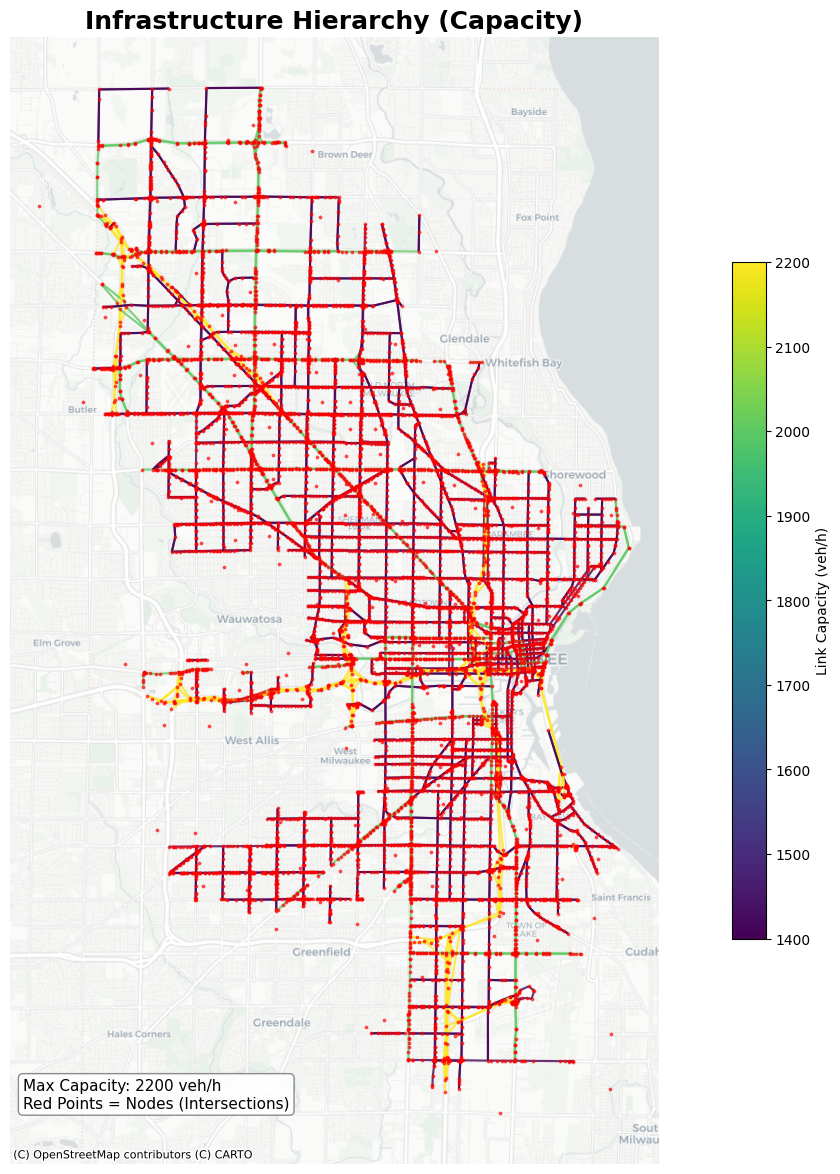

All tasks completed.

--- GENERATING BETWEENNESS CENTRALITY MAP ---
Generating graph on 8287 physical nodes and 14173 real links...
Calculating Betweenness Centrality (k=500)...
Betweenness map saved to: ../results/final_physical_network.html

--- GENERATING DEMAND MAPS ---
Analyzing demand for 234 zones.
Maps generated:
1. ../results/map_demand_centroids.html
2. ../results/map_origins.html
3. ../results/map_destinations.html

--- ALL TASKS COMPLETED ---
--- GENERATING REVISED DASHBOARD (Final Version) ---


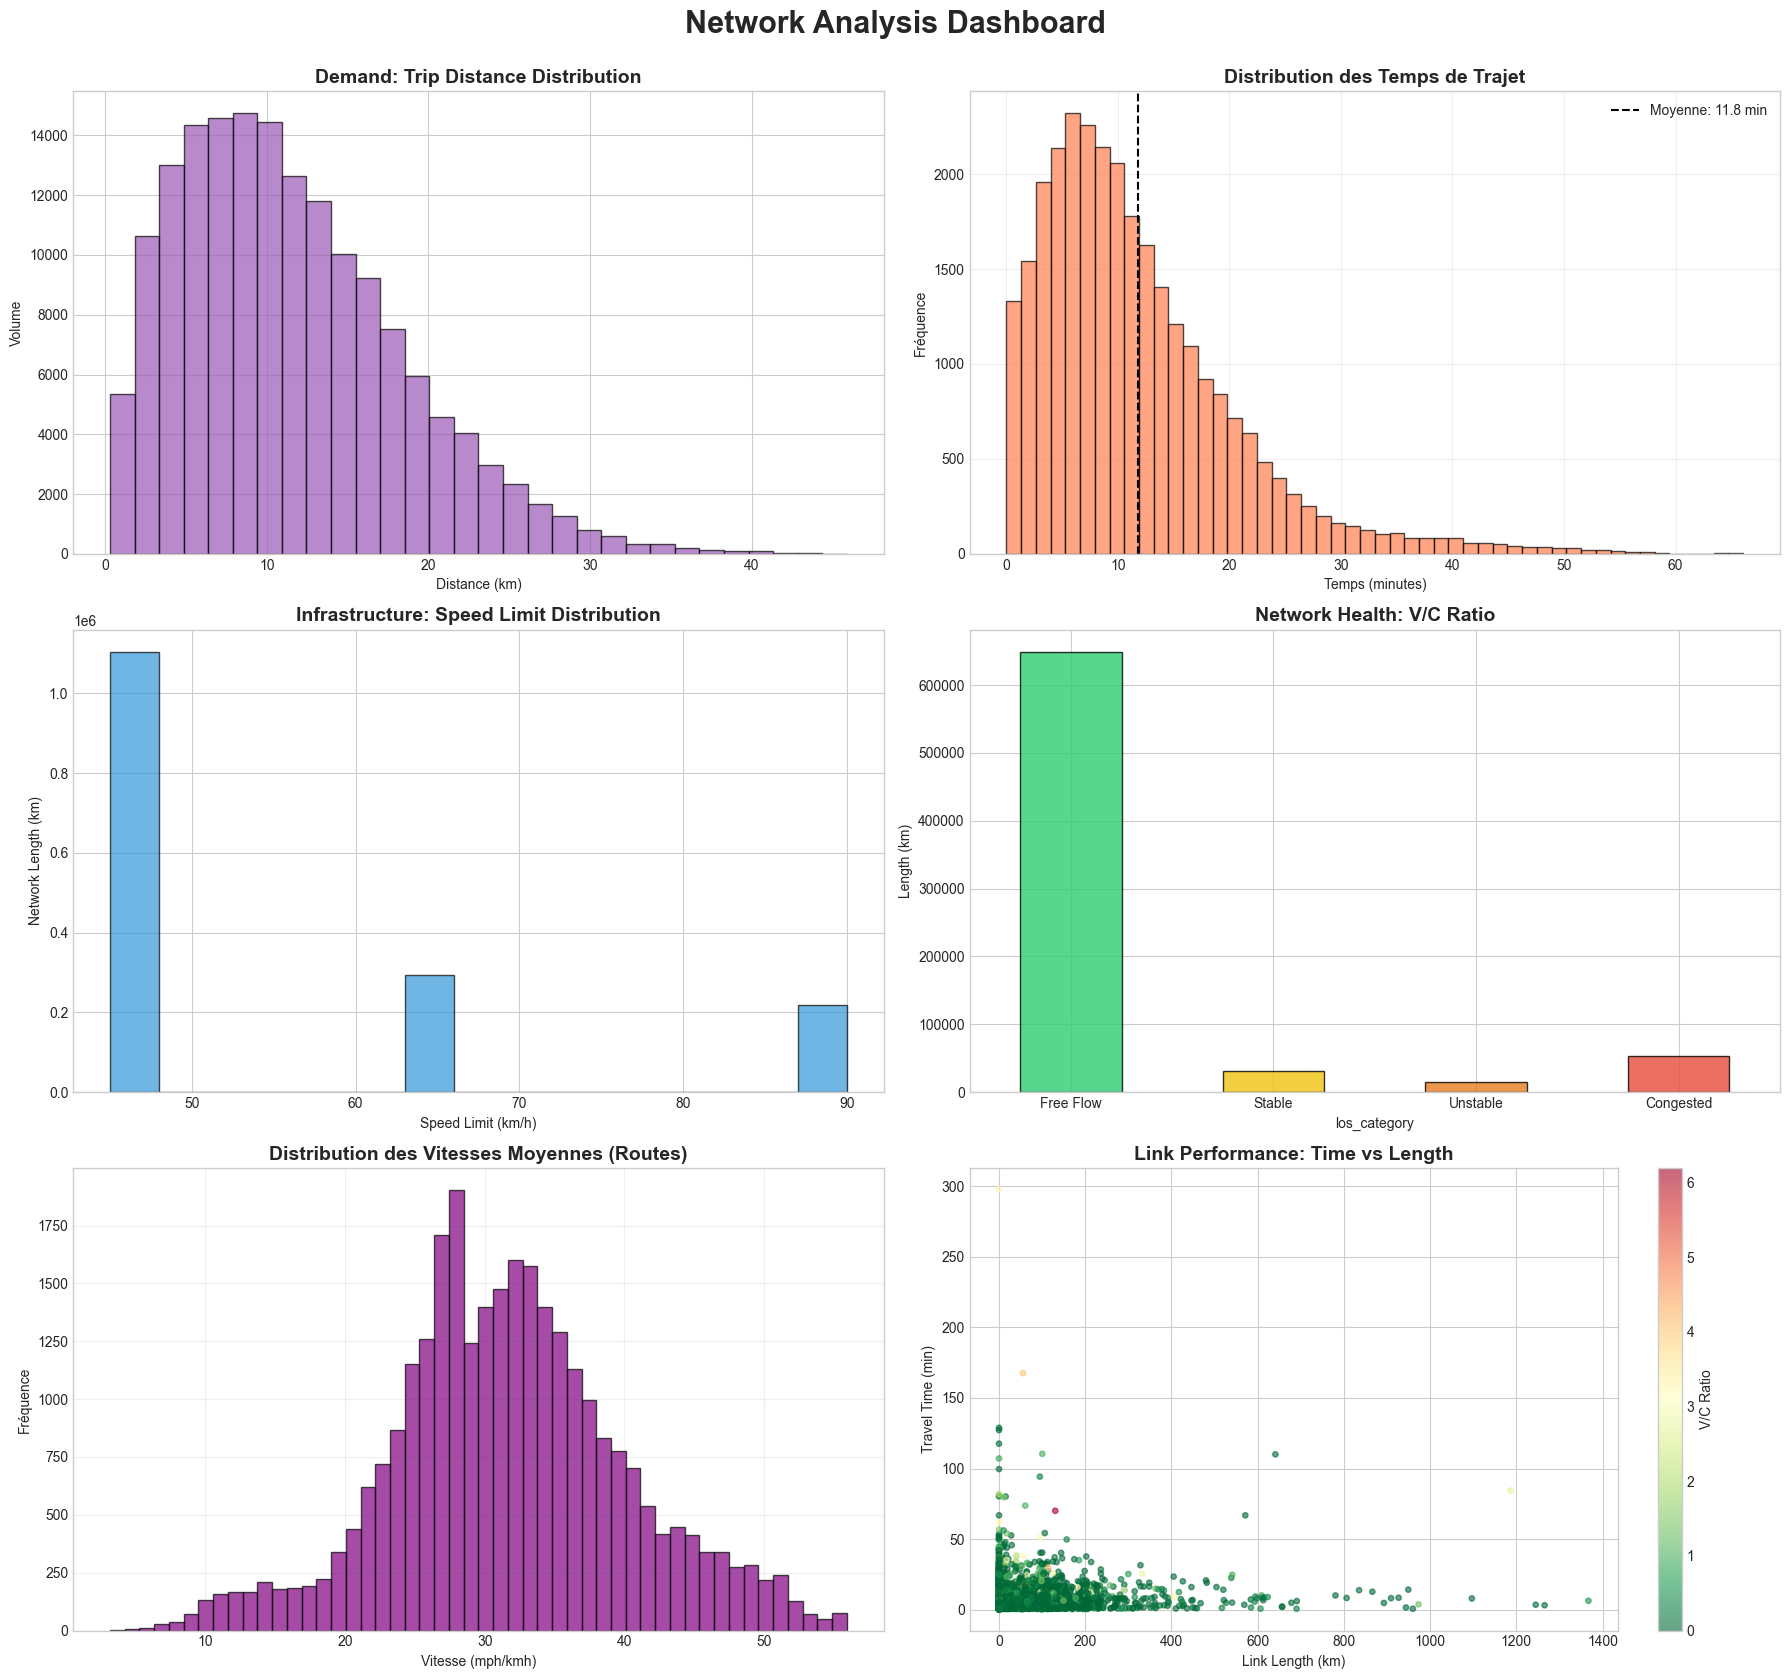

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import contextily as ctx
import folium
import os
import branca.colormap as cm
from shapely.geometry import LineString, Point
from folium.plugins import MarkerCluster, HeatMap
from IPython.display import display, IFrame

# ==============================================================================
# 1. CONFIGURATION & DATA LOADING
# ==============================================================================
# Define file paths (assuming files are in the current directory or adjust paths)
INPUT_NODES = '../data_preprocessed/node.csv'
INPUT_LINKS = '../data_preprocessed/link.csv'
INPUT_DEMAND = '../data_preprocessed/demand.csv'
INPUT_LINK_PERFORMANCE = '../data_preprocessed/link_performance.csv'
INPUT_ROUTE_ASSIGNMENT = '../data/route_assignment.csv'
INPUT_OD_PERFORMANCE = '../data_preprocessed/od_performance.csv'
NETWORK_PATH = '../data_preprocessed/'
OUTPUT_DIR = '../results/'

# Create output directory if it does not exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("--- LOADING DATA ---")
# Reading CSV files
nodes_df = pd.read_csv(INPUT_NODES)
links_df = pd.read_csv(INPUT_LINKS)
demand_df = pd.read_csv(INPUT_DEMAND)
link_perf_df = pd.read_csv(INPUT_LINK_PERFORMANCE)
# Optional files (loaded but might not be used in specific plots)
if os.path.exists(INPUT_ROUTE_ASSIGNMENT):
    route_assign_df = pd.read_csv(INPUT_ROUTE_ASSIGNMENT)
if os.path.exists(INPUT_OD_PERFORMANCE):
    od_perf_df = pd.read_csv(INPUT_OD_PERFORMANCE)

print(f"Nodes: {len(nodes_df)}")
print(f"Links: {len(links_df)}")
print(f"Performance Records: {len(link_perf_df)}")

# ==============================================================================
# 2. CONGESTION MAP GENERATION (Direct Method)
# ==============================================================================
print("\n--- START MAP GENERATION (Congestion V/C) ---")

# 2.1 Coordinate Dictionary Preparation
# Create a fast map Node ID -> (X, Y)
node_xy = pd.Series(
    list(zip(nodes_df['x_coord'], nodes_df['y_coord'])), 
    index=nodes_df['node_id']
).to_dict()

print(f"Indexed {len(node_xy)} nodes.")

# 2.2 Direct Geometry Creation on Performance Data
# Work on a copy to avoid touching original df
viz_df = link_perf_df.copy()

def get_geometry(row):
    try:
        start = node_xy[row['from_node_id']]
        end = node_xy[row['to_node_id']]
        return LineString([start, end])
    except KeyError:
        return None  # Return None if node not found

print("Constructing geometries...")
viz_df['geometry'] = viz_df.apply(get_geometry, axis=1)

# Remove rows where geometry wasn't created
viz_df = viz_df.dropna(subset=['geometry'])
print(f"Valid geometries created for {len(viz_df)} links.")

# 2.3 GeoDataFrame Creation
gdf = gpd.GeoDataFrame(viz_df, geometry='geometry', crs="EPSG:4326")

# 2.4 Connector Filter
# Use 'link_capacity' from link_perf_df. If > 90000 it is a connector
roads = gdf[gdf['link_capacity'] < 90000].copy()
print(f"Filtered road links: {len(roads)} (connectors excluded)")

# 2.5 Visual Metrics Calculation
# Calculate V/C Ratio (handle division by zero)
roads['vc_ratio'] = roads.apply(
    lambda x: x['volume'] / x['link_capacity'] if x['link_capacity'] > 0 else 0, 
    axis=1
)

# Style: Color (clipped at 1.2) and Width (log of volume)
roads['vc_visual'] = roads['vc_ratio'].clip(upper=1.2)
roads['l_width'] = 0.5 + (np.log1p(roads['volume']) / 1.5)

# Convert to Web Mercator for background map
roads_web = roads.to_crs(epsg=3857)

# 2.6 Plot
print("Generating plot...")
fig, ax = plt.subplots(figsize=(15, 12))

# Plot free roads first, then congested ones on top
roads_web.sort_values('vc_ratio').plot(
    ax=ax,
    column='vc_visual',
    cmap='RdYlGn_r',   # Red = High Traffic
    linewidth=roads_web['l_width'],
    capstyle='round',
    legend=True,
    vmin=0, vmax=1.2,
    legend_kwds={'label': "V/C Ratio (Saturation)", 'shrink': 0.6}
)

# Add Background
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.9)

# Decorations
ax.set_title('Traffic Congestion Map (Simulation)', fontsize=16, fontweight='bold')
ax.set_axis_off()

max_vc = roads['vc_ratio'].max()
info_text = f"Max V/C: {max_vc:.2f}\nRed = Congested"
ax.text(0.02, 0.05, info_text, transform=ax.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round'))

plt.tight_layout()
plt.show()
print("Done.")

# ==============================================================================
# 3. DELAY MAP GENERATION
# ==============================================================================
print("\n--- START MAP GENERATION (Delay) ---")

# 3.1 Data Preparation and Merge
# Merge link_perf_df (times/volumes) with links_df (length/speed)
attr_cols = ['link_id', 'length', 'free_speed'] 
if 'geometry' in links_df.columns: attr_cols.append('geometry')

df_delay = pd.merge(link_perf_df, links_df[attr_cols], on='link_id', how='inner')

# 3.2 Geometry Reconstruction (If needed)
if 'geometry' not in df_delay.columns:
    print("Reconstructing geometries from nodes...")
    # Reuse node_xy from previous block
    
    def get_geo(row):
        try:
            return LineString([node_xy[row['from_node_id']], node_xy[row['to_node_id']]])
        except KeyError: return None
        
    df_delay['geometry'] = df_delay.apply(get_geo, axis=1)
    df_delay = df_delay.dropna(subset=['geometry'])

# 3.3 Connector Filter
roads_delay = gpd.GeoDataFrame(df_delay, geometry='geometry', crs="EPSG:4326")
cap_col = 'link_capacity' if 'link_capacity' in roads_delay.columns else 'capacity'
roads_delay = roads_delay[roads_delay[cap_col] < 90000].copy()

# 3.4 Delay Calculation
tt_col = next((c for c in ['travel_time', 'avg_travel_time', 't_c'] if c in roads_delay.columns), None)

if tt_col:
    print(f"Calculating delay using real time column: {tt_col}")
    # Free Flow Time = Length / Free Speed
    roads_delay['free_flow_time'] = roads_delay['length'] / roads_delay['free_speed']
    # Delay = Real Time - Ideal Time
    roads_delay['delay'] = roads_delay[tt_col] - roads_delay['free_flow_time']
    roads_delay['delay'] = roads_delay['delay'].clip(lower=0)
else:
    print("WARNING: 'travel_time' column not found. Estimating delay with BPR formula.")
    roads_delay['vc'] = roads_delay['volume'] / roads_delay[cap_col]
    roads_delay['free_flow_time'] = roads_delay['length'] / roads_delay['free_speed']
    roads_delay['travel_time_est'] = roads_delay['free_flow_time'] * (1 + 0.15 * (roads_delay['vc']**4))
    roads_delay['delay'] = roads_delay['travel_time_est'] - roads_delay['free_flow_time']

# 3.5 Visualization
roads_web_delay = roads_delay.to_crs(epsg=3857)

# Metric: Specific Delay (Delay / Length)
roads_web_delay['delay_visual'] = roads_web_delay['delay'] / roads_web_delay['length'] 

# Clipping
vmax = roads_web_delay['delay_visual'].quantile(0.95)
roads_web_delay['l_width'] = 0.5 + (np.log1p(roads_web_delay['volume']) / 1.5)

fig, ax = plt.subplots(figsize=(15, 12))

roads_web_delay.sort_values('delay_visual').plot(
    ax=ax,
    column='delay_visual',
    cmap='magma_r', # Magma (Black/Purple -> Orange -> Yellow)
    linewidth=roads_web_delay['l_width'],
    capstyle='round',
    legend=True,
    vmin=0, vmax=vmax,
    legend_kwds={'label': "Specific Delay (h/km)", 'shrink': 0.6}
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.9)

ax.set_title('Traffic Delay Map', fontsize=16, fontweight='bold')
ax.set_axis_off()

# Info Box
tot_delay = roads_delay['delay'].sum()
text = f"Total Network Delay: {tot_delay:.2f} hours\nDark = Free Flow\nBright/Yellow = High Delay"
ax.text(0.02, 0.05, text, transform=ax.transAxes, fontsize=11,
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round'))

plt.tight_layout()
plt.show()

# ==============================================================================
# 4. INFRASTRUCTURE MAP GENERATION (CAPACITY)
# ==============================================================================
print("\n--- START MAP GENERATION (Infrastructure Capacity) ---")

# 4.1 Geometry Preparation
# Reuse node_xy

def get_link_geometry_infra(row):
    try:
        return LineString([node_xy[row['from_node_id']], node_xy[row['to_node_id']]])
    except KeyError:
        return None

links_viz = links_df.copy()
links_viz['geometry'] = links_viz.apply(get_link_geometry_infra, axis=1)

links_gdf = gpd.GeoDataFrame(links_viz.dropna(subset=['geometry']), geometry='geometry', crs="EPSG:4326")
nodes_gdf = gpd.GeoDataFrame(
    nodes_df, 
    geometry=gpd.points_from_xy(nodes_df.x_coord, nodes_df.y_coord), 
    crs="EPSG:4326"
)

# 4.2 Connector Filter
cap_col_infra = 'capacity' if 'capacity' in links_gdf.columns else 'link_capacity'
roads_infra = links_gdf[links_gdf[cap_col_infra] < 90000].copy()

# 4.3 Web Mercator Projection
roads_web_infra = roads_infra.to_crs(epsg=3857)
nodes_web_infra = nodes_gdf.to_crs(epsg=3857)

# 4.4 Plot
fig, ax = plt.subplots(figsize=(15, 12))

# Plot Links (Colored by Capacity)
roads_web_infra.plot(
    ax=ax, 
    column=cap_col_infra, 
    cmap='viridis',       # Purple (low) -> Yellow (high)
    linewidth=1.5, 
    alpha=0.8, 
    legend=True,
    legend_kwds={'label': 'Link Capacity (veh/h)', 'shrink': 0.6}
)

# Plot Nodes (Red Points) - Added to match the legend text
# Filter only physical nodes if 'type' column exists, otherwise all nodes
nodes_web_infra.plot(
    ax=ax,
    color='red',
    markersize=3,
    alpha=0.6,
    zorder=2
)

# Add Background
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.9)

# Decorations
ax.set_title('Infrastructure Hierarchy (Capacity)', fontsize=18, fontweight='bold')
ax.set_axis_off()

# Info Box
max_cap = roads_infra[cap_col_infra].max()
text = f"Max Capacity: {max_cap:.0f} veh/h\nRed Points = Nodes (Intersections)"
ax.text(0.02, 0.05, text, transform=ax.transAxes, fontsize=11,
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round'))

plt.tight_layout()
plt.show()
print("All tasks completed.")

# ==============================================================================
# 5. BETWEENNESS CENTRALITY MAP
# ==============================================================================
# Preprocessing for type
THRESHOLD_CAPACITY = 90000 
THRESHOLD_SPEED = 190
def get_link_type(row):
    cap = row.get('capacity', row.get('link_capacity', 0))
    spd = row.get('free_speed', row.get('speed_limit', 0))
    if cap > THRESHOLD_CAPACITY or spd > THRESHOLD_SPEED:
        return 'connector'
    return 'physical'

links_df['type'] = links_df.apply(get_link_type, axis=1)
physical_links = links_df[links_df['type'] == 'physical']
physical_node_ids = set(physical_links['from_node_id']).union(set(physical_links['to_node_id']))
nodes_df['type'] = nodes_df['node_id'].apply(lambda x: 'physical' if x in physical_node_ids else 'centroid')

print("\n--- GENERATING BETWEENNESS CENTRALITY MAP ---")

# 3.1 Data Selection (Physical only)
real_nodes = nodes_df[nodes_df['type'] == 'physical'].copy()
real_links = links_df[links_df['type'] == 'physical'].copy()

print(f"Generating graph on {len(real_nodes)} physical nodes and {len(real_links)} real links...")

# 3.2 Build Graph
G = nx.Graph()

# Add nodes
for _, row in real_nodes.iterrows():
    G.add_node(row['node_id'], pos=(row['x_coord'], row['y_coord']))

# Add edges
valid_ids = set(real_nodes['node_id'])
for _, row in real_links.iterrows():
    if row['from_node_id'] in valid_ids and row['to_node_id'] in valid_ids:
        # Use length as weight for centrality calculation
        weight = row.get('length', 1.0)
        G.add_edge(row['from_node_id'], row['to_node_id'], weight=weight)

# 3.3 Calculate Centrality
k_val = 500  # Approximation for speed
print(f"Calculating Betweenness Centrality (k={k_val})...")
betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True, k=k_val, seed=42)

# Map results back to dataframe
real_nodes['betweenness'] = real_nodes['node_id'].map(betweenness).fillna(0)

# 3.4 Visualization
center_lat = real_nodes["y_coord"].mean()
center_lon = real_nodes["x_coord"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles="cartodbpositron")

# Color scale (Blue -> Yellow -> Red)
vmax = real_nodes['betweenness'].quantile(0.99)
colormap = cm.LinearColormap(
    colors=['#0000FF', '#00FFFF', '#FFFF00', '#FF0000'], 
    vmin=0, 
    vmax=vmax,
    caption='Criticality (Betweenness Centrality)'
)

# Plot only relevant nodes (above average)
subset = real_nodes[real_nodes['betweenness'] > real_nodes['betweenness'].mean()]

for _, row in subset.iterrows():
    val = row['betweenness']
    
    # Dynamic radius
    radius = 3
    if val > real_nodes['betweenness'].quantile(0.95): radius = 5
    if val > real_nodes['betweenness'].quantile(0.99): radius = 8
    
    folium.CircleMarker(
        location=[row["y_coord"], row["x_coord"]],
        radius=radius,
        color=colormap(val),
        fill=True,
        fill_color=colormap(val),
        fill_opacity=0.7,
        popup=f"ID: {row['node_id']}<br>Score: {val:.4f}",
        tooltip=f"Betw: {val:.4f}"
    ).add_to(m)

m.add_child(colormap)
save_path_betw = os.path.join(OUTPUT_DIR, "final_physical_network.html")
m.save(save_path_betw)
print(f"Betweenness map saved to: {save_path_betw}")

# ==============================================================================
# 6. DEMAND ANALYSIS (Total, Origin, Destination)
# ==============================================================================
print("\n--- GENERATING DEMAND MAPS ---")

# 4.1 Aggregating Volume per Zone
# Total Production (Origins)
zone_prod = demand_df.groupby('o_zone_id')['volume'].sum().reset_index()
zone_prod.rename(columns={'o_zone_id': 'zone_id', 'volume': 'production'}, inplace=True)

# Total Attraction (Destinations)
zone_attr = demand_df.groupby('d_zone_id')['volume'].sum().reset_index()
zone_attr.rename(columns={'d_zone_id': 'zone_id', 'volume': 'attraction'}, inplace=True)

# Merge Statistics
zone_stats = pd.merge(zone_prod, zone_attr, on='zone_id', how='outer').fillna(0)
zone_stats['total_activity'] = zone_stats['production'] + zone_stats['attraction']

# 4.2 Merge with Centroid Geometry
centroids_geo = nodes_df[['node_id', 'x_coord', 'y_coord']].copy()
centroids_data = pd.merge(zone_stats, centroids_geo, left_on='zone_id', right_on='node_id', how='inner')

print(f"Analyzing demand for {len(centroids_data)} zones.")

# 4.3 Map 1: Total Activity (Centroids)
m1 = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles="cartodbpositron")

vmax_act = centroids_data['total_activity'].quantile(0.95)
colormap_act = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'], 
    vmin=0, vmax=vmax_act,
    caption='Total Traffic Volume (Origins + Destinations)'
)

for _, row in centroids_data.iterrows():
    val = row['total_activity']
    if val > 0:
        radius = 2 + (val**0.5) / 10  
        folium.CircleMarker(
            location=[row["y_coord"], row["x_coord"]],
            radius=radius,
            color=colormap_act(val),
            fill=True, fill_color=colormap_act(val), fill_opacity=0.6,
            popup=f"Zone: {row['zone_id']}<br>Prod: {row['production']}<br>Attr: {row['attraction']}",
            tooltip=f"Vol: {val:.0f}"
        ).add_to(m1)

m1.add_child(colormap_act)
save_path_total = os.path.join(OUTPUT_DIR, "map_demand_centroids.html")
m1.save(save_path_total)

# 4.4 Helper Function for O/D Maps
def create_demand_map(data, title, colors, filename, val_col='volume'):
    m = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles="cartodbpositron")
    vmax = data[val_col].quantile(0.95)
    colormap = cm.LinearColormap(colors=colors, vmin=0, vmax=vmax, caption=title)
    
    for _, row in data.iterrows():
        val = row[val_col]
        if val > 0:
            radius = 3 + (val**0.5) / 8 
            folium.CircleMarker(
                location=[row["y_coord"], row["x_coord"]],
                radius=radius,
                color=colormap(val),
                fill=True, fill_color=colormap(val), fill_opacity=0.7,
                popup=f"Zone: {row['zone_id']}<br>Vol: {val:.0f}",
                tooltip=f"Vol: {val:.0f}"
            ).add_to(m)
    m.add_child(colormap)
    m.save(filename)
    return filename

# 4.5 Map 2 & 3: Origins and Destinations
# Prepare specific DataFrames
df_origins = pd.merge(zone_prod.rename(columns={'production': 'volume'}), centroids_geo, left_on='zone_id', right_on='node_id', how='inner')
df_destinations = pd.merge(zone_attr.rename(columns={'attraction': 'volume'}), centroids_geo, left_on='zone_id', right_on='node_id', how='inner')

# Generate Maps
file_orig = create_demand_map(
    df_origins, 
    "Generated Traffic (Origins)", 
    ['#E0F7FA', '#006064'], # Cyan -> Dark Cyan
    os.path.join(OUTPUT_DIR, "map_origins.html")
)

file_dest = create_demand_map(
    df_destinations, 
    "Attracted Traffic (Destinations)", 
    ['#FFFDE7', '#B71C1C'], # Yellow -> Red
    os.path.join(OUTPUT_DIR, "map_destinations.html")
)

print(f"Maps generated:\n1. {save_path_total}\n2. {file_orig}\n3. {file_dest}")
print("\n--- ALL TASKS COMPLETED ---")

# ==============================================================================
# 7. FINAL REVISED DASHBOARD (3x2)
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("--- GENERATING REVISED DASHBOARD (Final Version) ---")

# 1. Prepare Data
# Check/Load Route Assignment for this section specifically if needed
if 'route_assign_df' not in locals():
    if os.path.exists(INPUT_ROUTE_ASSIGNMENT):
        route_assign_df = pd.read_csv(INPUT_ROUTE_ASSIGNMENT)
    else:
        route_assign_df = pd.DataFrame()

# Data Filters & Merges (Re-ensure variables are available)
cap_col = 'capacity' if 'capacity' in links_df.columns else 'link_capacity'
spd_col = 'free_speed' if 'free_speed' in links_df.columns else 'speed_limit'
len_col = 'length' if 'length' in links_df.columns else 'distance'
THRESHOLD_CAP = 90000

phys_links = links_df[links_df[cap_col] < THRESHOLD_CAP].copy()
cols_needed = ['link_id', spd_col, len_col, cap_col]
df_stats = pd.merge(link_perf_df, links_df[cols_needed], on='link_id', how='left')
final_cap_col = next((c for c in df_stats.columns if 'capacity' in c), 'link_capacity')
df_stats = df_stats[df_stats[final_cap_col] < THRESHOLD_CAP].copy()

# Metric Calculations
df_stats['vc_ratio'] = df_stats['volume'] / df_stats[final_cap_col]
df_stats['los_category'] = pd.cut(df_stats['vc_ratio'], bins=[-1, 0.5, 0.8, 1.0, 100], labels=['Free Flow', 'Stable', 'Unstable', 'Congested'])
df_stats['free_flow_time'] = df_stats[len_col] / df_stats[spd_col]

tt_col = next((c for c in ['travel_time', 'avg_travel_time', 't_c'] if c in df_stats.columns), None)
if tt_col:
    df_stats['real_time'] = df_stats[tt_col]
else:
    df_stats['real_time'] = df_stats['free_flow_time'] * (1 + 0.15 * (df_stats['vc_ratio']**4))

# Trip Lengths
node_xy = pd.Series(list(zip(nodes_df['x_coord'], nodes_df['y_coord'])), index=nodes_df['node_id']).to_dict()
def calc_distance(row):
    try:
        p1 = np.array(node_xy[row['o_zone_id']]); p2 = np.array(node_xy[row['d_zone_id']])
        dist = np.linalg.norm(p1 - p2)
        return dist * 111 * 1.3 if abs(p1[0]) < 180 else (dist/1000) * 1.3
    except: return 0
demand_viz = demand_df.copy()
demand_viz['trip_length_km'] = demand_viz.apply(calc_distance, axis=1)

# Route Calculations
if not route_assign_df.empty:
    dist_col_r = 'distance_mile' if 'distance_mile' in route_assign_df.columns else 'total_distance'
    time_col_r = 'total_travel_time' if 'total_travel_time' in route_assign_df.columns else 'travel_time'
    
    # Ensure time column for plotting
    if 'total_travel_time' not in route_assign_df.columns and time_col_r in route_assign_df.columns:
        route_assign_df['total_travel_time'] = route_assign_df[time_col_r]

    route_assign_df['avg_speed'] = np.where(
        route_assign_df[time_col_r] > 0,
        (route_assign_df[dist_col_r] / route_assign_df[time_col_r]) * 60, 0
    )
    route_assign_df = route_assign_df[route_assign_df['avg_speed'] < 150]

# 2. Plotting (3x2 Layout)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
fig.suptitle('Network Analysis Dashboard', fontsize=22, fontweight='bold', y=0.96)

# --- ROW 1: DEMAND & TIME ---
# 1. Trip Distances
axes[0, 0].hist(demand_viz['trip_length_km'], weights=demand_viz['volume'], bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Demand: Trip Distance Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Distance (km)')
axes[0, 0].set_ylabel('Volume')

# 2. Route Travel Time (NEW REQUEST)
if not route_assign_df.empty and 'total_travel_time' in route_assign_df.columns:
    axes[0, 1].hist(route_assign_df['total_travel_time'], bins=50, color='coral', edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Distribution des Temps de Trajet', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Temps (minutes)')
    axes[0, 1].set_ylabel('Fréquence')
    axes[0, 1].grid(True, alpha=0.3)
    avg_time = route_assign_df['total_travel_time'].mean()
    axes[0, 1].axvline(avg_time, color='black', linestyle='--', label=f'Moyenne: {avg_time:.1f} min')
    axes[0, 1].legend()
else:
    axes[0, 1].text(0.5, 0.5, 'No Route Data', ha='center')

# --- ROW 2: INFRASTRUCTURE & HEALTH ---
# 3. Speed Limits
axes[1, 0].hist(phys_links[spd_col], weights=phys_links[len_col], bins=15, color='#3498db', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Infrastructure: Speed Limit Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Speed Limit (km/h)')
axes[1, 0].set_ylabel('Network Length (km)')

# 4. V/C Ratio
los_stats = df_stats.groupby('los_category', observed=False)[len_col].sum()
los_stats.plot(kind='bar', ax=axes[1, 1], color=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'], edgecolor='black', alpha=0.8, rot=0)
axes[1, 1].set_title('Network Health: V/C Ratio', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Length (km)')

# --- ROW 3: ROUTE PERFORMANCE & SCATTER ---
# 5. Route Speed Distribution
if not route_assign_df.empty:
    axes[2, 0].hist(route_assign_df['avg_speed'], bins=50, color='purple', edgecolor='black', alpha=0.7)
    axes[2, 0].set_title('Distribution des Vitesses Moyennes (Routes)', fontsize=14, fontweight='bold')
    axes[2, 0].set_xlabel('Vitesse (mph/kmh)')
    axes[2, 0].set_ylabel('Fréquence')
    axes[2, 0].grid(True, alpha=0.3)
else:
    axes[2, 0].text(0.5, 0.5, 'No Route Data', ha='center')

# 6. Scatter Time vs Length
sample = df_stats.sample(min(5000, len(df_stats)))
sc = axes[2, 1].scatter(sample[len_col], sample['real_time']*60, c=sample['vc_ratio'], cmap='RdYlGn_r', s=15, alpha=0.6)
axes[2, 1].set_title('Link Performance: Time vs Length', fontsize=14, fontweight='bold')
axes[2, 1].set_xlabel('Link Length (km)')
axes[2, 1].set_ylabel('Travel Time (min)')
plt.colorbar(sc, ax=axes[2, 1], label='V/C Ratio')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()